## Solving a equation with PINNs using the neurodiffeq module

The differential equation to solve is
$$\sin \! \left(2 x \right) \left(\frac{d}{d x}g \! \left(x \right)\right)+2 \sin \! \left(x \right) \left(g \! \left(x \right) \sin \! \left(x \right)-1\right) = 0$$
where $x \in [0, \pi/2]$ and the initial condition is

$$ g(x)|_{x_0} = 0, \, \,\, \text{with } \, \, x_0 = \pi / 4 $$


In [1]:
# Modules-----------------------------------------------------------------------
import numpy             as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# Neurodiff classes and functions--------------------------------------------------
from neurodiffeq.monitors   import Monitor1D
from neurodiffeq            import diff
from neurodiffeq.networks   import FCNN
from neurodiffeq.conditions import IVP
from neurodiffeq.solvers    import Solver1D
from neurodiffeq.monitors   import MonitorSpherical
from neurodiffeq.generators import Generator1D
from neurodiffeq.networks   import Swish
from torch.optim            import Adam
from itertools              import chain
#-------------------------------------------------------------------------------

/home/lgomez/anaconda3/envs/cosmoNN/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from neurodiffeq.utils import set_tensor_type #This is not necessary 
set_tensor_type(device='cpu', float_bits=64)

The analytical solution to this equation is 
$$g(x) =  \sin (x) -  \cos (x) $$

Training Progress:  20%|█▉        | 997/5000 [00:16<00:55, 71.50it/s]

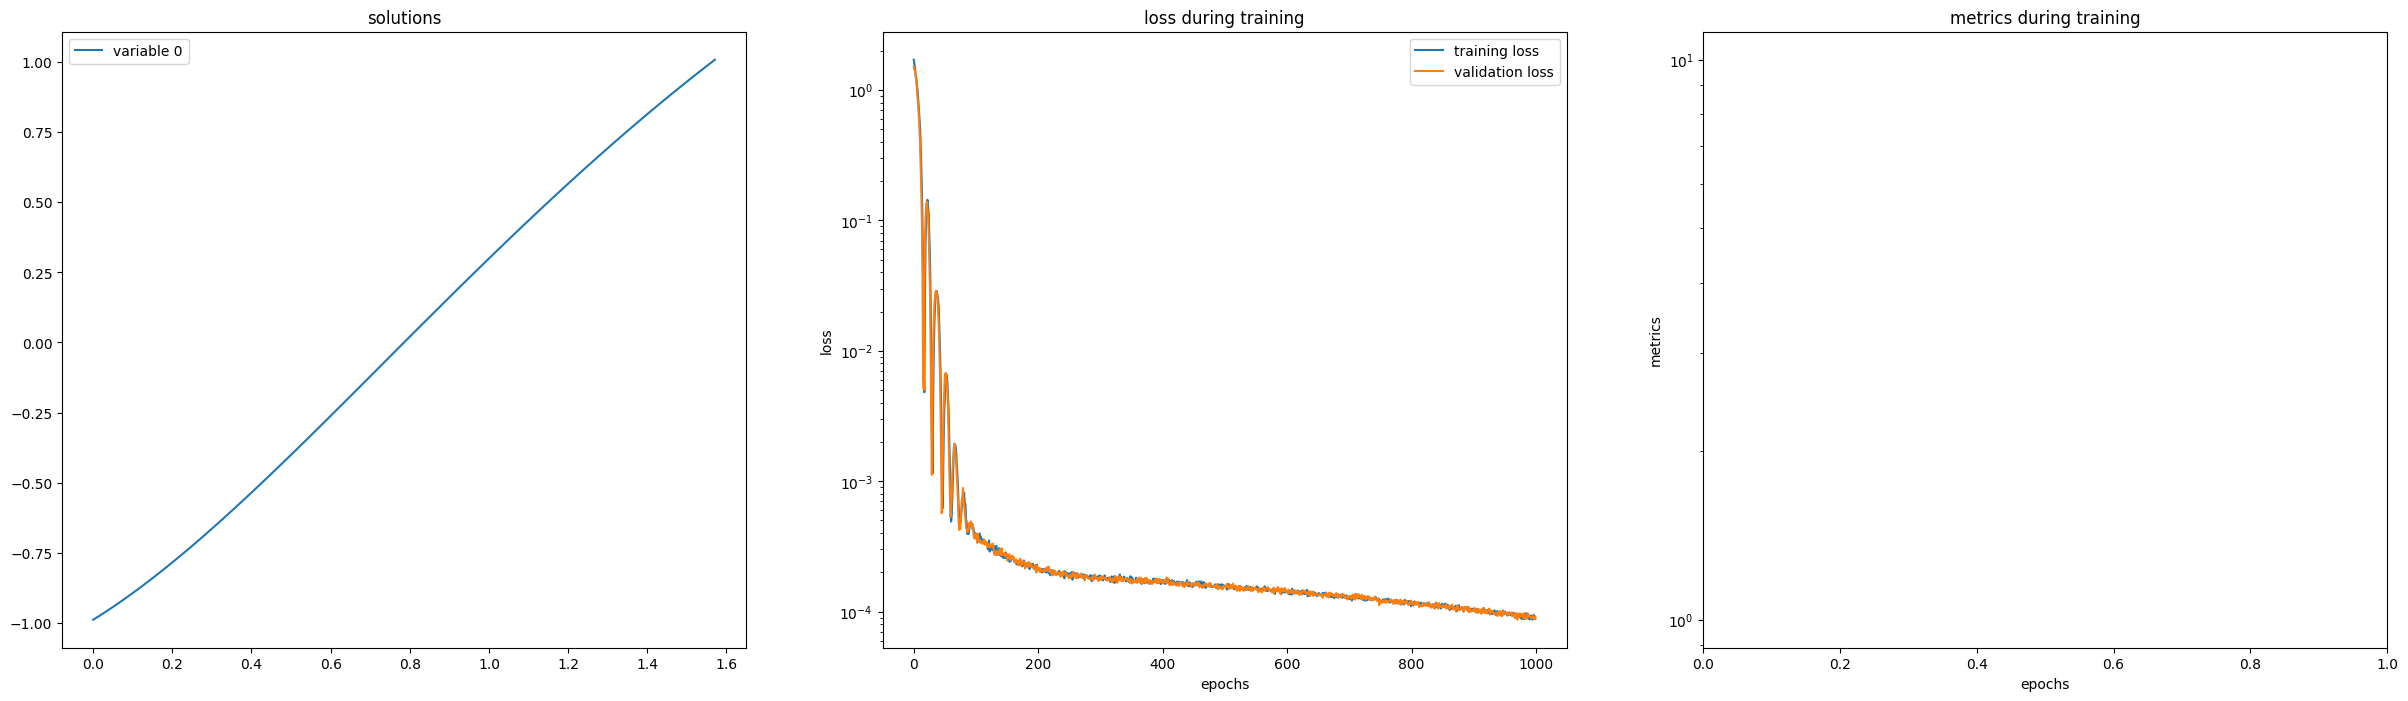

Training Progress: 100%|██████████| 5000/5000 [01:13<00:00, 68.14it/s]


In [ ]:
#Let's put the limits of the function and the conditions

x_min, x_max = 0.0, np.pi/2. # Domain of the function

x_0, g_0 = np.pi/4, 0.0 # The conditions

# Let's create a monitor first
monitor = Monitor1D(t_min = x_min, t_max = x_max, check_every=1000)

# and turn it into a callback instance to show the train every 2500 epochs
monitor_callback = monitor.to_callback(fig_dir='/home/lgomez/PINNs/Plots')

equation = lambda g, x: [torch.sin(2*x) * diff(g, x, order = 1 ) + 2 * torch.sin(x) * ( g * torch.sin(x) - 1 )]# Specify the equation

init_val = [IVP(t_0 = x_0, u_0 = g_0)] # IVP is a function of neurodiff to specify the initial condition 

'''
----------------
There are different types of distribution implemented in Neurodiffeq 

 uniform       equally-spaced       log-spaced       log-spaced-noisy       chebyshev       
 
 etc... see more in the API: https://neurodiffeq.readthedocs.io/en/latest/api.html
----------------
In the case of log-spaced, this distribution can't start from 0, so we need to define a litte epsilon as the inferior limit
'''
epsilon = 1e-8

train_gen = Generator1D(size=1000, t_min = x_min + epsilon, t_max = x_max, method='log-spaced-noisy') #Generator of random points with log distribution
#train_gen = Generator1D(size=1000, t_min = x_min, t_max = x_max, method='uniform') 

valid_gen = Generator1D(size=200, t_min = x_min, t_max = x_max, method='uniform') #Generator of random points with uniform distribution

'''
The Fully connected architecture of the Neural network (FCNN)
- Nº of hidden layers = 3
- Nº of units per layer (64, 128, 64)
- Just 1 input and 1 output (i.e x -> g(x))
- Activation function Swish =  x * sigmoid(x), there are many activation functions as Sigmoid, Tanh, RELU, SILU, GELU, SIN, ... , etc.
'''
nets = [FCNN(n_input_units = 1, n_output_units=1,hidden_units=(64, 128, 64), actv = Swish)]

'''
Optimizer

Adam
'''

opt  = Adam(chain.from_iterable(n.parameters() for n in nets), lr=1e-3) # With a learning rate ('steps') 0.001 

# Solver for the 1D system of equations in this case, only 1 equation
solver = Solver1D(
    ode_system = equation,
    conditions = init_val,
    t_min = x_min,
    t_max = x_max,
    train_generator = train_gen,
    valid_generator = valid_gen,
    nets = nets,
    optimizer = opt)

#Call the function fit of solver to train the model (in this case 'nets') and using callbacks to check the train every 2500 epochs
solver.fit(max_epochs=5000, callbacks=[monitor_callback])

In [16]:
# Get the solution
solution = solver.get_solution()

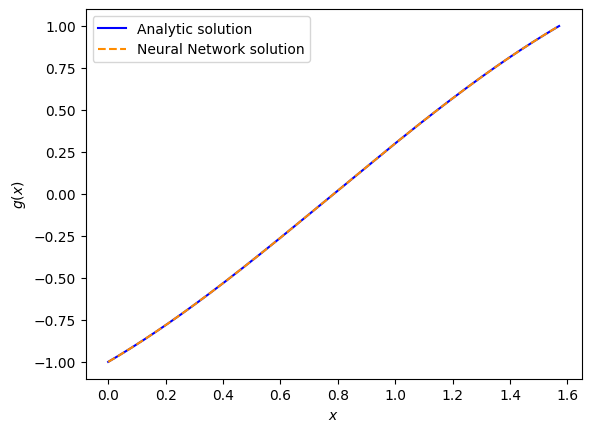

In [17]:
x = np.linspace(x_min,x_max,1000) #Define an array to evaluate the function

sol_net = solution(x,to_numpy=True) #call the solution in that array

sol_an = lambda x: - np.cos(x) + np.sin(x) # Analytic solution

plt.plot(x, sol_an(x), c = 'blue', label = 'Analytic solution')
plt.plot(x, sol_net, c = 'darkorange',linestyle = '--', label="Neural Network solution")
plt.xlabel(r'$x$')
plt.ylabel(r'$g(x)$')
plt.legend(loc="best")
plt.show()

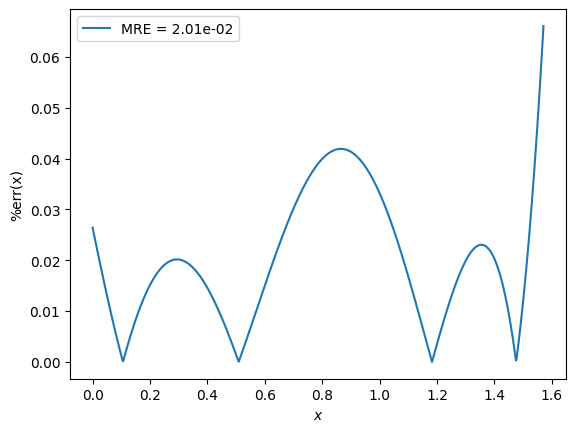

In [20]:
#Check the accuracy of the solution 
error =  100*np.abs(sol_an(x) - sol_net)/np.abs(sol_an(x))
mean_error = np.mean(error)
plt.plot(x,error, label = rf"MRE = {mean_error:.2e}") #label is meanrelative error
plt.ylabel('%err(x)')
plt.xlabel(r'$x$')
plt.legend(loc="best")
plt.show()

In [22]:
'''
How to save the neural network model in a file? 

Like this!
'''
torch.save(nets,'//home/lgomez/PINNs/model.ph')

# Come back to the original problem

If you make a clever change of variables like

$$ f(x) =  \dfrac{g(x)}{\sin (x)}$$

then

$$ f(x) =  -\cot (x) + 1 $$

and if $x = \arctan (r)$ where $r \in [0, \infty]$ we obtain

$$ f(r) = 1 - \frac{1}{r}  $$

and if you look carefully this function **is the Schwarzschild solution when you set $r_{+} = 1$.** To look it more in detail, you can reconstruct the form of this function in a plot.

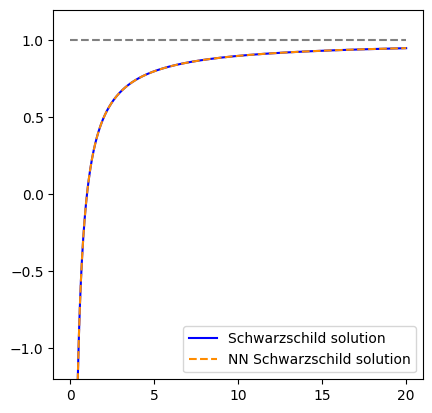

In [21]:
#Define the plot
fig, ax = plt.subplots()

#set the range of r coordinate for this case

r_min = x_min + epsilon # r coordinate + epsilon because Schw metric explotes in the origin 

r_max =  20 # gravitational radius (i.e 20 [2GM/c^2]) 

r = np.linspace(r_min,r_max,1000) 

x = np.arctan(r) #inverse transformation 

#--------- Solution for g(x) in x coordinate
sol_net = solution(x,to_numpy=True)

sol_an = lambda x: - np.cos(x) + np.sin(x) # Analytic solution

#--------- Solution for f(x) in x coordinate
schw_net = sol_net/np.sin(x)

schw_an = sol_an(x)/np.sin(x)

# to check in r coordinate we can see the plots for the r values and the functions values evaluated in the corresponding x(r)

ax.plot(r, schw_an, c = 'blue', label = 'Schwarzschild solution')

ax.plot(r, schw_net, c = 'darkorange',linestyle = '--', label="NN Schwarzschild solution")

ax.hlines(y=1, xmin=0, xmax=20, color='gray',linestyle='--')

ax.set_ylim(-1.2,1.2)

plt.legend(loc="best")
ax.set_box_aspect(1)
plt.show()